In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import plotly.express as px
from IPython.display import display
import dask.dataframe as dd
import dask.array as da

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset, here you can use the same path you used in the previous notebook
df = pd.read_csv("/content/drive/MyDrive/Unsupervised Learning/Data/df_syn_en.csv")

In [ ]:
df.head()

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,...,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
0,97061800,2020-01-01,30,B,11,21,11,10,ZZR1LT6,QLRUBN9,...,4408909195,BE,BE,0.0,FEU1,G,108.0,372254.40,0,0
1,85945189,2020-01-01,40,B,11,21,11,40,SWF9S4X,7JD1S2X,...,6907221000,CN,CN,8.0,A,Y,11352.0,375751.20,0,0
2,77854751,2020-01-01,20,B,11,21,11,40,X4XT6P8,WI9O3I5,...,6208221000,CN,CN,5.2,FCN1,B,20.7,5353.02,0,0
3,46925060,2020-01-01,40,B,11,21,43,40,K7LCQTZ,6LI9721,...,9403501000,VN,VN,0.0,C,Y,9218.0,1477645.40,0,0
4,34131149,2020-01-01,20,B,11,21,11,10,1HMVIVH,RZ871V1,...,710807000,VN,VN,27.0,A,B,24000.0,6364800.00,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dec_num                 54000 non-null  int64  
 1   dec_date                54000 non-null  object 
 2   dec_custom_code         54000 non-null  int64  
 3   imp_dec_code            54000 non-null  object 
 4   imp_trd_code            54000 non-null  int64  
 5   imp_typ_code            54000 non-null  int64  
 6   collect_code            54000 non-null  int64  
 7   typ_transport_code      54000 non-null  int64  
 8   dec_mark                54000 non-null  object 
 9   importer                54000 non-null  object 
 10  ovs_cust_code           48799 non-null  object 
 11  exps_carr_code          9538 non-null   object 
 12  HS10                    54000 non-null  int64  
 13  country_ship_code       54000 non-null  object 
 14  country_orig_code       54000 non-null

| Attribute                | Explanation                                                                                         |
|--------------------------|-----------------------------------------------------------------------------------------------------|
| dec_num                  | import declaration num                                                                              |
| dec_date                 | Date import declaration was submitted                                                               |
| dec_custom_code          | Declared customs code                                                                               |
| imp_dec_code             | Type code of import declaration, such as general and simplified declaration                         |
| imp_trd_code             | Type code of import transaction                                                                     |
| imp_typ_code             | Type code for import use, such as raw materials for domestic consumption and export                 |
| collect_code             | Type code for collection                                                                            |
| typ_transport_code       | Type code for transport and container                                                               |
| dec_mark                 | Type code for reporter’s name and trade name                                                        |
| importer                 | Importer's customs code                                                                             |
| ovs_cust_code            | Overseas customer's business name code                                                              |
| exps_carr_code           | Code of express method and express company                                                          |
| HS10                     | 10-digit HS code                                                                                    |
| country_ship_code        | Overseas shipping country code of declared goods                                                    |
| country_orig_code        | Type Code of country of origin                                                                      |
| trff_rate                | Tax rate of the item (%)                                                                            |
| trff_class_code          | Dividing code according to the tax rate of the item                                                 |
| country_orig_mark_code   | Code according to the presence or absence of country of origin indication and reasons for exemption from indication |
| dec_weight               | Item weight excluding packaging (KG)                                                                |
| taxabal_price_KRW        | Amount actually paid by the buyer (KRW)                                                             |
| crime_yn                 | Whether it is high crime cargo                                                                      |
| key_exposure             | Whether a high-weighted criminal among the high-crime items                                         |


In [ ]:
# 'dec_num' and 'dec_date' are identifiers and date respectively
# We'll drop them as they might not be useful for dimensionality reduction
df = df.drop(columns=['dec_num', 'dec_date'])

In [ ]:
# Handle missing values
df = df.dropna()

Dimensionality reduction like PCA is typically applied to the features, not the labels, thus we separate them.

In [ ]:
# Separating out the features and labels
features = [col for col in df.columns if col not in ['key_exposure', 'crime_yn']]
x = df.loc[:, features].values
labels = df[["key_exposure", "crime_yn"]]

labels

,key_exposure,crime_yn
7,0,0
8,0,0
14,0,0
15,0,0
18,0,0
...,...,...
53978,0,0
53987,0,0
53990,0,0
53995,0,0


In [ ]:
# Separate the numeric and categorical columns
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in features if col not in numeric_features]

# Apply one-hot encoding to categorical columns
encoded_data = pd.get_dummies(df[categorical_features])

# Standardizing the numeric features
scaled_data = StandardScaler().fit_transform(df[numeric_features])

# Combining the scaled numeric data and the encoded categorical data
x = np.concatenate([scaled_data, encoded_data.values], axis=1)

In [ ]:
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
# Apply PCA
pca = PCA(n_components=2)  # We'll reduce to 2 components for visualization
principalComponents = pca.fit_transform(x)

In [ ]:
# Creating a DataFrame with the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])
principalDf

,Principal Component 1,Principal Component 2
0,-2.579800,0.247592
1,2.678641,-1.658900
2,1.890011,-1.543496
3,1.791087,-0.641927
4,-2.494996,0.344023
...,...,...
8096,1.174471,-0.718825
8097,-2.833785,-0.743517
8098,0.109383,-0.348876
8099,0.908649,-1.361277


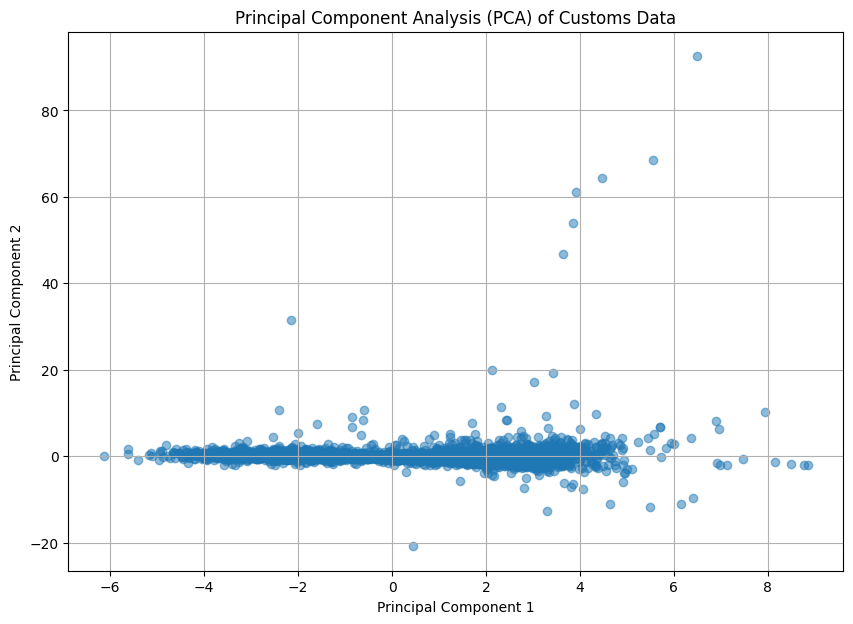

In [ ]:
# Plotting the two principal components
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'], alpha=0.5)
plt.title('Principal Component Analysis (PCA) of Customs Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
# Load the original dataset
df_original = pd.read_csv("/content/drive/MyDrive/Unsupervised Learning/Data/df_syn_en.csv")

# Add back your original data to the pca_df for easy inspection upon hover
principalDf['dec_num'] = df_original['dec_num'] # you can add more columns if needed

# Create an interactive scatter plot
fig = px.scatter(principalDf, x='Principal Component 1', y='Principal Component 2', hover_data=['dec_num'])

# Show the figure
fig.show()

In [ ]:
declaration_numbers = [51990309, 74749447, 13715298, 26380846, 32462631]
selected_records = df_original[df_original['dec_num'].isin(declaration_numbers)]

display(selected_records)

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,...,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
1837,32462631,2020-01-14,40,B,11,21,11,40,AX4CW6G,ULQ35CZ,...,9001903000,HK,CN,0.0,CIT,Y,0.4,1905.56,0,0
2363,51990309,2020-01-17,40,B,11,21,11,10,TPQTA2O,3QP5HIS,...,9404900000,CN,CN,8.0,A,Y,12.0,277.20,0,0
4731,74749447,2020-02-05,40,B,11,21,14,40,Q9ZG6R5,NI19P46,...,9506290000,US,US,0.0,FUS1,S,70.0,28952.00,1,1
4847,26380846,2020-02-06,40,B,15,21,11,40,WS7HRMI,OS43ICR,...,9015900000,JP,US,0.0,C,E,11.0,8710.90,0,0
4859,13715298,2020-02-06,30,B,11,21,11,10,GHEKNRK,Q6LQLF9,...,8513109090,CN,CN,8.0,A,B,281.0,3596.80,0,0


In [ ]:
# Generate sorted indices for Principal Components
sorted_idx_1 = pca.components_[0].argsort()[::-1]
sorted_idx_2 = pca.components_[1].argsort()[::-1]

# Assuming you used pandas get_dummies for one-hot encoding:
data_encoded = pd.get_dummies(df)  # This might have been done in your preprocessing.
features = data_encoded.columns.tolist()

# Verify lengths
print("Length of features list:", len(features))
print("Number of features in PCA:", pca.components_.shape[1])

# Assuming the lengths now match:
if len(features) == pca.components_.shape[1]:
    print("Top features for Principal Component 1:")
    for idx in sorted_idx_1[:5]:
        print(features[idx], pca.components_[0][idx])

    print("\nTop features for Principal Component 2:")
    for idx in sorted_idx_2[:5]:
        print(features[idx], pca.components_[1][idx])
else:
    print("Still a mismatch. Need further investigation.")

Length of features list: 12103
Number of features in PCA: 12103
Top features for Principal Component 1:
trff_class_code_FEU1 0.1622125075955198
country_ship_code_US 0.13232339077695138
country_orig_code_US 0.13180176352173464
country_orig_code_IT 0.10568786526337982
country_ship_code_IT 0.10291127258410201

Top features for Principal Component 2:
trff_class_code_FPE1 0.3698167185919903
country_orig_code_PE 0.3698167185919903
country_ship_code_PE 0.3698167185919903
importer_O5VQE9S 0.2164234523825156
ovs_cust_code_QI0497M 0.2164234523825156


The Principal Components (PCs) represent combinations of your original features that capture the most variance in the data. The first PC captures the most variance, the second PC (which is orthogonal to the first) captures the second most, and so on. The features listed for each PC are those that have the highest absolute values for the coefficients in the linear combinations defining the PCs. Essentially, these are the features that most influence each PC.

From a customs perspective:



*   The features in the first principal component suggest that the origin and shipping countries, especially US, play a significant role in the variability of customs declarations. It may indicate trade patterns, common goods, or a prevalent trade route.
*   The features in the second principal component seem more varied but suggest specific importers, origin countries, and declaration marks might have some common patterns or correlations.




In [ ]:
# Create a dataframe that combines principal components, declaration numbers, and labels
plot_df = principalDf.copy()
plot_df['dec_num'] = df_original['dec_num']
plot_df['crime_yn'] = labels['crime_yn']
plot_df['key_exposure'] = labels['key_exposure']

# Visualization for `crime_yn` label:
fig1 = px.scatter(plot_df, x='Principal Component 1', y='Principal Component 2',
                  color=plot_df['crime_yn'].astype(str),
                  title='2D PCA for `crime_yn`',
                  hover_data=['dec_num'],  # displaying declaration numbers
                  color_discrete_sequence=px.colors.qualitative.Set1)

# Show the plot
fig1.show()

In [ ]:
# Map the numeric/boolean values to string labels
crime_label_map = {
    0: "No Crime",
    1: "Crime",
    False: "No Crime",
    True: "Crime",
    np.nan: "Not Inspected"
}

labels['crime_yn'] = labels['crime_yn'].map(crime_label_map)

# Counting the records for each category
crime_counts = labels['crime_yn'].value_counts(dropna=False)  # include NaN counts
crime_counts.index = crime_counts.index.fillna('Not Inspected')  # Just in case, though this line may be redundant now

# Create a dataframe from the counts for visualization
crime_df = pd.DataFrame({'Label': crime_counts.index, 'Count': crime_counts.values})

# Plot
fig = px.pie(crime_df, names='Label', values='Count', title='Distribution of Records by Crime Status')
fig.show()

<ipython-input-18-d23640800464>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
crime_df = plot_df[plot_df['crime_yn'] == 'Crime'][['Principal Component 1', 'Principal Component 2']]
latest_100 = plot_df.tail(100).copy()

# Calculate distance for each new entry to the nearest crime
def compute_distance(row):
    entry = row[['Principal Component 1', 'Principal Component 2']]
    distances = np.sqrt((crime_df['Principal Component 1'] - entry[0])**2 +
                        (crime_df['Principal Component 2'] - entry[1])**2)
    return distances.min()

latest_100['distance_to_crime'] = latest_100.apply(compute_distance, axis=1)

# Mark the closest 10% for inspection
number_to_inspect = int(0.10 * len(latest_100))
latest_100_sorted = latest_100.sort_values(by='distance_to_crime')
latest_100_sorted['inspect'] = [True] * number_to_inspect + [False] * (len(latest_100_sorted) - number_to_inspect)

# Interactive visualization
fig = px.scatter(plot_df, x='Principal Component 1', y='Principal Component 2',
                 color=np.where(plot_df['dec_num'].isin(latest_100_sorted[latest_100_sorted['inspect']]['dec_num']), 'Inspected', 'Not inspected'),
                 title='PCA with Inspected Entries Highlighted',
                 hover_data=['dec_num', 'crime_yn'])

fig.show()

# Static table of inspected items
inspected_items = latest_100_sorted[latest_100_sorted['inspect']]
display(inspected_items[['dec_num', 'distance_to_crime']])


,dec_num,distance_to_crime
8001,49568211,NaN
8002,69358627,NaN
8003,23867303,NaN
8004,27424757,NaN
8005,59779561,NaN
8006,38379766,NaN
8007,11637308,NaN
8008,91486719,NaN
8009,27666131,NaN
8010,77985050,NaN


In [ ]:
# Filter out entries in latest_100 with distance_to_crime of 0.0
filtered_100 = latest_100[latest_100['distance_to_crime'] > 0]

# Mark the closest 10% for inspection from the filtered data
number_to_inspect_filtered = int(0.10 * len(filtered_100))
filtered_100_sorted = filtered_100.sort_values(by='distance_to_crime')
filtered_100_sorted['inspect'] = [True] * number_to_inspect_filtered + [False] * (len(filtered_100_sorted) - number_to_inspect_filtered)

# Interactive visualization
fig_filtered = px.scatter(plot_df, x='Principal Component 1', y='Principal Component 2',
                          color=np.where(plot_df['dec_num'].isin(filtered_100_sorted[filtered_100_sorted['inspect']]['dec_num']), 'Inspected', 'Not inspected'),
                          title='PCA with Inspected Entries Highlighted (Zero Distances Removed)',
                          hover_data=['dec_num', 'crime_yn'])

fig_filtered.show()

# Static table of inspected items from filtered data
inspected_items_filtered = filtered_100_sorted[filtered_100_sorted['inspect']]
display(inspected_items_filtered[['dec_num', 'distance_to_crime']])
